### Calculate connectivity matrix between ROIs

In [2]:
# Run Functional connectivity on HBN data
# import
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
import glob
import os
from nilearn import signal
from scipy import stats
import nibabel as nib
from os.path import exists
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sys
import seaborn as sns

In [3]:
# Load subject fmri data
# This will loop across subjects
projectdir = '/scratch/groups/jyeatman/HBN_FC/'
inputdir = projectdir + 'input'
#subs = glob.glob(datadir + 'sub-*') # this gets the full path
subs = [os.path.basename(x) for x in glob.glob(inputdir + '/sub-*')]
print('Found ' + str(len(subs)) + ' subjects in inputdir')

Found 262 subjects in inputdir


In [4]:
# Where to save outputs: 
surfacedir = projectdir + 'surface/statMaps/'
imagedir =  projectdir + 'surface/images/'
outputdir = projectdir + 'surface/ROI2ROI/'

if not os.path.exists(surfacedir):
    os.makedirs(surfacedir)

if not os.path.exists(imagedir):
    os.makedirs(imagedir)
    
# Paths to surface ROIs from Kalanit's group - Rosenke 2021
#roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/FreeSurfer/'
#roi_names = ['MPM_lh_OTS.label','MPM_lh_pOTS.label']

# Paths to surface ROIs based on Gari's coordinates (Lerma-Usabiaga PNAS 2018, converted vol2surf)
#roidir =  '/home/groups/jyeatman/ROI_Atlases/'
#roi_names = ['VWFA1.label.gii','VWFA2.label.gii']

# Paths to surface ROIs from Emily
roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/'
roi_names = ['lh_pOTS_chars.label','lh_mOTS_chars.label','lh_IFS_S_chars.label']
# the IOS ROI is a character selective ROI from Rosenke 2021, looks like OWFA
faces = False
if faces==True:
    roi_names = ['lh_pFus_faces.label','lh_mFus_faces.label','lh_IFS_chars.label']
   
# Which task
task = 'rest' # options are 'rest' or 'movie'
hemi = 'left' # right or left
seed_hemi = 'left'
# which correlation to save
corr_type = 'fisherz' # options are 'rval', 'fisherz'

overwrite = False
createFigs = False # create connectivity maps per subject
saveFigs = False   # Save png files of connectivity maps
saveMaps = False   # Save actual connectivity map as a curv file that can 
# be loaded to Freeview
saveGroup = True

# Run on a subset of data for debugging
subs = ['sub-NDARAC349YUC']

droptp = [0,1,2,3,4,5]
fd_thresh = 0.5
fd_vol_thresh = 90 # include only scans with >90% usable volumes

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
# Load LH surface to get its size
white_left = surface.load_surf_data(fsaverage['white_left'])
# Load RH surface to get its size
white_right = surface.load_surf_data(fsaverage['white_right'])

# Load subject list
subject_file = projectdir+ 'subs_preprocessed_restingstate_movieDM_meanFD05_SNR15_FD05_90_WIAT_FilteredAfterScrubbing_0.5_0.2.csv'
if task == 'rest':
    subject_file = projectdir+ 'subs_preprocessed_onlyrest_meanFD05_SNR15_FD05_90_WIAT.csv'
    numvols = 738 # (375 -6) *2
elif task == 'movie':
    subject_file = projectdir+ 'subs_preprocessed_onlymovie_meanFD05_SNR15_FD05_90_WIAT.csv'
    numvols = 744 # 750 - initial 6 vols
sub_list = pd.read_csv(subject_file)
subs = sub_list['participant_id']

# parse command-line arguments; to use on Sherlock
# start = int(sys.argv[1])
# end = int(sys.argv[2])
# subs = subs[start:end]

sub_count = len(subs)
print('Running on ' + str(sub_count) + ' subjects')

/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/surface/surface.py:671: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


Running on 224 subjects


In [5]:
# silly loop to rename roi names for plotting, we want to keep the long names to locate their files
roi_short_names = roi_names.copy()
for roi_i in range(len(roi_names)):
    if "IOS" in roi_names[roi_i]:
        roi_short_names[roi_i] = "IOS"
    if "pOTS" in roi_names[roi_i]:
        roi_short_names[roi_i] = "VWFA-1"
    if "mOTS" in roi_names[roi_i]:
        roi_short_names[roi_i] = "VWFA-2"
    if "IFS" in roi_names[roi_i]:
        roi_short_names[roi_i] = "IFS"
    if "pFus" in roi_names[roi_i]:
        roi_short_names[roi_i] = "FFA-1"
    if "mFus" in roi_names[roi_i]:
        roi_short_names[roi_i] = "FFA-2"

print(roi_names)
print(roi_short_names)    

['lh_pOTS_chars.label', 'lh_mOTS_chars.label', 'lh_IFS_S_chars.label']
['VWFA-1', 'VWFA-2', 'IFS']


In [6]:
# save ROIs from atlas as separate files
atlas = False
if atlas == True:
    rois_to_save = [b'S_front_inf',b'S_intrapariet_and_P_trans']
    roidir = '/home/groups/jyeatman/ROI_Atlases/Destrieux/'
    destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
    parcellation = destrieux_atlas['map_' + hemi]
    labels = destrieux_atlas['labels']
    for rr in range(len(rois_to_save)):
        cur_roi = np.where(parcellation == labels.index(rois_to_save[rr]))[0]
        cur_roi = cur_roi.astype(int)
        # roi_names for the Atlas are bytes, not strings
        # (begin with 'b' --> need to be decoded inco UTF8)
        rois_to_save[rr] = rois_to_save[rr].decode()
        filepath = roidir + rois_to_save[rr]
        nib.freesurfer.io.write_annot(filepath, cur_roi, ctab= [1], names=[rois_to_save[rr]])

In [60]:
# Try loading a gii surface file that was previously saved
# When the seed ROI is not in the same hemisphere that we want to analyse, we actually need to load two surfaces:
# one to calculate the seed_timeseries of the source ROI, and another to extract all timeseries of all 
# vertices in the other hemisphere

# Loop over subjects and compute timeseries for each seed ROI
group_roi_timeseries = np.zeros((len(subs),numvols,len(roi_names)))
group_roi_timeseries[:] = np.NaN

for ii,sub in enumerate(subs):
    rois_timeseries = np.empty((numvols,len(roi_names)))
    output_subfilename = sub + '_task-' + task + '_' + corr_type + '_' + hemi[0] + 'h.npy'
    # Load data for full hemisphere
    func_file = subs.iloc[ii] + '_task-' + task + '_'+ hemi[0] + 'h.gii'
    if not exists(projectdir + '/vol2surf/' + func_file):
        print('Cant find ' + func_file)
        continue
    else:
        print('Loading sub # ' + str(ii) + ' ' + func_file)
        run_data = surface.load_surf_data(projectdir + '/vol2surf/' + func_file)
        # saving as gii and loading the surface seems to transpose the data
        # we want our data to be vertices * timepoints
        if run_data.shape[0] < run_data.shape[1]:
            run_data = np.transpose(run_data)
        print('Original Data Vertices by Timepoints')
        print(run_data.shape) 
        # we want to drop the same volumes from the second run as well - only for resting state
        if task =='rest':
            droptp2 = [x + int(run_data.shape[1]/2) for x in droptp]
            dropall = droptp + droptp2
            print('dropping volumes: ' + str(dropall))

        elif task == 'movie':
            dropall = droptp
            print('dropping volumes: ' + str(dropall))

        run_data = np.delete(run_data,dropall,axis=1)
        print('After dropping initial 6 Timepoints, Vertices by Timepoints')
        print(run_data.shape) 
        # TBD - implement scrubbing

        # Load data for seed ROI if different from target hemisphere    
        if seed_hemi == hemi:
            run_data_seed = run_data.copy()
        else:
            func_file_seed = subs.iloc[ii] + '_task-' + task + '_'+ seed_hemi[0] + 'h.gii'
            print('Loading sub # ' + str(ii) + ' ' + func_file_seed)
            run_data_seed = surface.load_surf_data(projectdir + '/vol2surf/' + func_file_seed)
            # saving as gii and loading the surface seems to transpose the data
            # we want our data to be vertices * timepoints
            if run_data_seed.shape[0] < run_data_seed.shape[1]:
                run_data_seed = np.transpose(run_data_seed)
            print('Original Data Vertices by Timepoints')
            print(run_data_seed.shape) 
            # we want to drop the same volumes from the second run as well - only for resting state
            if task =='rest':
                droptp2 = [x + int(run_data_seed.shape[1]/2) for x in droptp]
                dropall = droptp + droptp2
                print('dropping volumes: ' + str(dropall))

            elif task == 'movie':
                dropall = droptp
                print('dropping volumes: ' + str(dropall))

            run_data_seed = np.delete(run_data_seed,dropall,axis=1)
            print('After dropping initial 6 Timepoints, Vertices by Timepoints')
            print(run_data_seed.shape) 


        # Compute the mean time series for the ROI
        for rr in range(len(roi_names)):
            # Load ROI
            if atlas == False:
                cur_roi = surface.load_surf_data(roidir + roi_names[rr])
                cur_roi = cur_roi.astype(int) 
                print('Analyzing ROI ' + roidir + roi_names[rr])
            else:
                cur_roi = np.where(parcellation == labels.index(roi_names[rr]))[0]
                cur_roi = cur_roi.astype(int)
                # roi_names for the Atlas are bytes, not strings
                # (begin with 'b' --> need to be decoded inco UTF8)
                roi_names[rr] = roi_names[rr].decode()
                print('Analyzing ROI ' + roidir + ' ' + roi_names[rr])

            seed_timeseries = np.nanmean(run_data_seed[cur_roi], axis=0)
            # To plot mean timeseries:
#             fig, ax = plt.subplots(figsize =(4, 3))
#             ax.plot(seed_timeseries)
#             ax.set_title('Seed timeseries ' + subs.iloc[ii] + ' ' + roi_names[rr])
#             ax.set_xlabel('Volume number')
#             ax.set_ylabel('Normalized signal')
#             print()

            rois_timeseries[:,rr] = seed_timeseries
            group_roi_timeseries[ii,:,rr] = seed_timeseries


    sub_filepath = outputdir + sub + '_ROI2ROI_' + task + '_' + hemi 
    #np.save(sub_filepath,rois_timeseries)

#group_filepath
output_groupfilename = f'{outputdir}ROI2ROI_N{len(subs)}_{task}_{hemi}'
if faces == True:
    output_groupfilename = f'{outputdir}ROI2ROI_faces_N{len(subs)}_{task}_{hemi}'
    
np.save(output_groupfilename,group_roi_timeseries)    
#     if saveGroup:
#         nib.freesurfer.io.write_morph_data(output_groupfilename+ '.curv',group_mean)        
#         #save also as numpy array
#         np.save(output_groupfilename,group_map)

Loading sub # 0 sub-NDARAA948VFH_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 1 sub-NDARAB458VK9_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 18 sub-NDARBZ925PRF_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 19 sub-NDARCG159AAP_task-rest_lh.gii
Original Dat

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 35 sub-NDARDN393BJH_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 36 sub-NDARDP786HE6_task-rest_lh.gii
Original Dat

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 52 sub-NDARFF061VUK_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 53 sub-NDARFG713PLR_task-rest_lh.gii
Original Dat

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 69 sub-NDARGU844NZ3_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 70 sub-NDARGV781AMW_task-rest_lh.gii
Original Dat

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 86 sub-NDARJC010YYF_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 87 sub-NDARJC559WW5_task-rest_lh.gii
Original Dat

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 103 sub-NDARKN633WZA_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 104 sub-NDARKR155ME9_task-rest_lh.gii
Original D

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 120 sub-NDARMA584EM0_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 121 sub-NDARMK825WAX_task-rest_lh.gii
Original D

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 137 sub-NDARPE752VYE_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 138 sub-NDARPF395NV5_task-rest_lh.gii
Original D

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 154 sub-NDARRW974PEF_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 155 sub-NDARRX897XV1_task-rest_lh.gii
Original D

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 171 sub-NDARVC195NLH_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 172 sub-NDARVC673HFA_task-rest_lh.gii
Original D

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 188 sub-NDARWR247CE1_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 189 sub-NDARWR888KKT_task-rest_lh.gii
Original D

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 205 sub-NDARYA503XVQ_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 206 sub-NDARYA955CY1_task-rest_lh.gii
Original D

Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 222 sub-NDARZW873DN3_task-rest_lh.gii
Original Data Vertices by Timepoints
(163842, 750)
dropping volumes: [0, 1, 2, 3, 4, 5, 375, 376, 377, 378, 379, 380]
After dropping initial 6 Timepoints, Vertices by Timepoints
(163842, 738)
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_mFus_faces.label
Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_IFS_chars.label
Loading sub # 223 sub-NDARZY101JNB_task-rest_lh.gii
Original D

In [7]:
output_groupfilename = f'{outputdir}ROI2ROI_N{len(subs)}_{task}_{hemi}'
print(output_groupfilename)
#np.save(output_groupfilename,group_roi_timeseries)
sub_count = len(subs)

/scratch/groups/jyeatman/HBN_FC/surface/ROI2ROI/ROI2ROI_N224_rest_left


In [8]:
output_groupfilename = f'{outputdir}ROI2ROI_N{sub_count}_{task}_{hemi}'
if faces == True:
    output_groupfilename = f'{outputdir}ROI2ROI_faces_N{sub_count}_{task}_{hemi}'
    
print(output_groupfilename)
group_roi_timeseries = np.load(output_groupfilename + '.npy')

/scratch/groups/jyeatman/HBN_FC/surface/ROI2ROI/ROI2ROI_N224_rest_left


Text(0.5, 1.0, 'Average across subjects, N= 224')

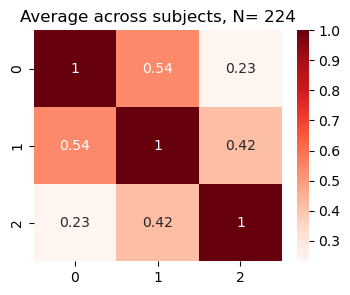

In [9]:
plotSingleSubs = False
all_subs = pd.DataFrame(columns=['sub'])
all_subs_corr = np.empty((len(subs),len(roi_names),len(roi_names)))
all_subs_corr[:] = np.NaN
for s, sub in enumerate(subs):
    rois_timeseries = group_roi_timeseries[s,:,:]
    sub_corr = np.empty((len(roi_names),len(roi_names)))
    sub_corr[:] = np.NaN
    sub_corr = np.corrcoef(np.transpose(rois_timeseries))
    
    all_subs_corr[s,:,:] = sub_corr
    sub_corr = pd.DataFrame(sub_corr)
    sub_corr.columns = roi_names
    if plotSingleSubs:
        fig, ax = plt.subplots(figsize =(4, 3))
        sns.heatmap(sub_corr,cmap='Reds',annot=True, yticklabels=roi_short_names,xticklabels=roi_short_names)
    
fig, ax = plt.subplots(figsize =(4, 3))
sns.heatmap(np.nanmean(all_subs_corr,axis=0),cmap='Reds',annot=True)
plt.title('Average across subjects, N= ' + str(len(subs)))
    

In [33]:
# Break it down to a dataframe with columns for correlations
all_subs_df = pd.DataFrame(columns=['sub'])
for s, sub in enumerate(subs):
    for r1 in range(len(roi_names)):
        for r2 in range(len(roi_names)):
        #cur_ind = r + s*len(runs)
            all_subs_df.loc[s,'sub'] = sub
            if not r2==r1:
                all_subs_df.loc[s,f"{roi_short_names[r1]}_{roi_short_names[r2]}"] = all_subs_corr[s,r1,r2]

In [34]:
all_subs_df.drop(labels=['VWFA-2_VWFA-1','IFS_VWFA-1','IFS_VWFA-2'],axis=1, inplace=True)
# Calculate Delta (difference between ROIs)
all_subs_df['Delta'] =  all_subs_df.apply(lambda row: row['VWFA-2_IFS'] - row['VWFA-1_IFS'], axis = 1)
# Ratio
all_subs_df['Ratio'] =  all_subs_df.apply(lambda row: (row['VWFA-2_IFS'] - row['VWFA-1_IFS'])/(row['VWFA-2_IFS'] + row['VWFA-1_IFS']), axis = 1)
all_subs_df

,sub,VWFA-1_VWFA-2,VWFA-1_IFS,VWFA-2_IFS,Delta,Ratio
0,sub-NDARAA948VFH,0.412815,0.267867,0.177036,-0.090831,-0.204160
1,sub-NDARAB458VK9,0.819928,0.529696,0.639191,0.109495,0.093674
2,sub-NDARAC349YUC,0.619859,0.303648,0.306566,0.002919,0.004783
3,sub-NDARAC350BZ0,0.522216,-0.103622,0.224779,0.328402,2.710546
4,sub-NDARAG340ERT,0.787631,0.380380,0.342235,-0.038145,-0.052787
...,...,...,...,...,...,...
219,sub-NDARZL113CU0,0.561947,0.077073,0.097121,0.020048,0.115090
220,sub-NDARZM903TNL,0.488408,-0.016170,0.237100,0.253269,1.146377
221,sub-NDARZT940RZG,0.786824,0.511668,0.538214,0.026546,0.025285
222,sub-NDARZW873DN3,0.312141,0.076697,0.645213,0.568515,0.787516


In [35]:
# combine with behavioral data and save
all_subs_df = all_subs_df.rename(columns={'sub':'participant_id'})
big_df=pd.merge(all_subs_df,sub_list,on='participant_id')
big_df

,participant_id,VWFA-1_VWFA-2,VWFA-1_IFS,VWFA-2_IFS,Delta,Ratio,Unnamed: 0,X,preproc,existsRun1,...,Barratt_Total_Edu,Barratt_P1_Occ,Barratt_P2_Occ,Barratt_Total_Occ,Barratt_Total,TOWRE_PDE_Raw,TOWRE_PDE_Scaled,TOWRE_SWE_Raw,TOWRE_SWE_Scaled,TOWRE_Total_Scaled
0,sub-NDARAA948VFH,0.412815,0.267867,0.177036,-0.090831,-0.204160,1,3,1,1,...,18.0,40.0,30.0,35.0,53.0,24.0,96.0,63.0,109.0,103.0
1,sub-NDARAB458VK9,0.819928,0.529696,0.639191,0.109495,0.093674,2,4,1,1,...,15.0,25.0,30.0,27.5,42.5,50.0,105.0,80.0,100.0,103.0
2,sub-NDARAC349YUC,0.619859,0.303648,0.306566,0.002919,0.004783,3,6,1,1,...,18.0,0.0,NaN,0.0,18.0,35.0,97.0,77.0,109.0,103.0
3,sub-NDARAC350BZ0,0.522216,-0.103622,0.224779,0.328402,2.710546,4,7,1,1,...,16.5,0.0,40.0,40.0,56.5,62.0,130.0,95.0,126.0,130.0
4,sub-NDARAG340ERT,0.787631,0.380380,0.342235,-0.038145,-0.052787,5,23,1,1,...,21.0,NaN,NaN,0.0,21.0,40.0,99.0,71.0,95.0,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,sub-NDARZL113CU0,0.561947,0.077073,0.097121,0.020048,0.115090,220,1536,1,1,...,16.5,40.0,5.0,22.5,39.0,31.0,116.0,53.0,113.0,115.0
220,sub-NDARZM903TNL,0.488408,-0.016170,0.237100,0.253269,1.146377,221,1540,1,1,...,18.0,45.0,45.0,45.0,63.0,48.0,117.0,82.0,121.0,120.0
221,sub-NDARZT940RZG,0.786824,0.511668,0.538214,0.026546,0.025285,222,1547,1,1,...,16.5,35.0,30.0,32.5,49.0,46.0,98.0,79.0,94.0,96.0
222,sub-NDARZW873DN3,0.312141,0.076697,0.645213,0.568515,0.787516,223,1552,1,1,...,18.0,40.0,40.0,40.0,58.0,32.0,85.0,86.0,108.0,96.0


In [27]:
# to open in R we need to remove all the hyphens (R will turn them to colons)
big_df_forR = big_df.copy()
big_df_forR.columns = big_df_forR.columns.str.replace('-', '')
big_df_forR.columns
big_df_forR.to_csv(projectdir + 'surface/analyses/' + os.path.basename(output_groupfilename) + '.csv')

In [36]:
big_df.describe()

,VWFA-1_VWFA-2,VWFA-1_IFS,VWFA-2_IFS,Delta,Ratio,Unnamed: 0,X,preproc,existsRun1,existsRun2,...,Barratt_Total_Edu,Barratt_P1_Occ,Barratt_P2_Occ,Barratt_Total_Occ,Barratt_Total,TOWRE_PDE_Raw,TOWRE_PDE_Scaled,TOWRE_SWE_Raw,TOWRE_SWE_Scaled,TOWRE_Total_Scaled
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.0,224.0,224.0,...,219.000000,215.000000,186.000000,219.000000,219.000000,220.000000,220.000000,221.000000,221.000000,220.000000
mean,0.543271,0.231697,0.415458,0.183760,0.329404,112.500000,773.924107,1.0,1.0,1.0,...,17.931507,27.674419,32.930108,33.664384,51.595890,36.736364,95.622727,71.343891,98.045249,96.695455
std,0.159668,0.193014,0.185514,0.174300,0.941615,64.807407,459.827730,0.0,0.0,0.0,...,2.851020,16.131355,13.280364,11.098616,12.662247,16.540901,17.621812,21.023781,18.922275,18.441639
min,0.074667,-0.415209,-0.169219,-0.402844,-7.168231,1.000000,3.000000,1.0,1.0,1.0,...,4.500000,0.000000,0.000000,0.000000,9.500000,0.000000,55.000000,6.000000,55.000000,53.000000
25%,0.444468,0.088689,0.287162,0.059006,0.072223,56.750000,369.750000,1.0,1.0,1.0,...,16.500000,17.500000,30.000000,30.000000,46.500000,24.000000,82.750000,62.000000,86.000000,84.000000
50%,0.549520,0.243577,0.429044,0.188030,0.255067,112.500000,743.500000,1.0,1.0,1.0,...,18.000000,35.000000,35.000000,35.000000,54.500000,40.000000,97.000000,74.000000,98.000000,98.000000
75%,0.658041,0.350434,0.538344,0.288748,0.522539,168.250000,1193.500000,1.0,1.0,1.0,...,21.000000,40.000000,45.000000,40.000000,61.000000,50.000000,108.000000,86.000000,110.000000,110.000000
max,0.885499,0.753886,0.797969,0.711004,6.603303,224.000000,1554.000000,1.0,1.0,1.0,...,21.000000,45.000000,45.000000,45.000000,66.000000,64.000000,135.000000,108.000000,141.000000,140.000000


In [20]:
#plot_data = all_subs_df[['sub','VWFA-1_IFS','VWFA-2_IFS','VWFA-1_VWFA-2']]
plot_data = all_subs_df[['sub','VWFA-1_IFS','VWFA-2_IFS']]
#plot_data = all_subs_df[['sub','FFA-1_IFS','FFA-2_IFS','FFA-1_FFA-2']]
plot_data.describe()

,VWFA-1_IFS,VWFA-2_IFS
count,224.000000,224.000000
mean,0.231697,0.415458
std,0.193014,0.185514
min,-0.415209,-0.169219
25%,0.088689,0.287162
50%,0.243577,0.429044
75%,0.350434,0.538344
max,0.753886,0.797969


In [21]:
plot_data_long = plot_data.melt(id_vars='sub',var_name='IFS_ROI',value_name = 'FC',ignore_index=True)
#plot_data_long=plot_data_long.reset_index()
plot_data_long

,sub,IFS_ROI,FC
0,sub-NDARAA948VFH,VWFA-1_IFS,0.267867
1,sub-NDARAB458VK9,VWFA-1_IFS,0.529696
2,sub-NDARAC349YUC,VWFA-1_IFS,0.303648
3,sub-NDARAC350BZ0,VWFA-1_IFS,-0.103622
4,sub-NDARAG340ERT,VWFA-1_IFS,0.380380
...,...,...,...
443,sub-NDARZL113CU0,VWFA-2_IFS,0.097121
444,sub-NDARZM903TNL,VWFA-2_IFS,0.237100
445,sub-NDARZT940RZG,VWFA-2_IFS,0.538214
446,sub-NDARZW873DN3,VWFA-2_IFS,0.645213


In [22]:
# Try to color by magnitude of difference
#plot_data['Delta'] =  plot_data.apply(lambda row: row.vwfa2_IFSwords - row.vwfa1_IFSwords, axis = 1)
plot_data['Delta'] =  plot_data.apply(lambda row: row['VWFA-2_IFS'] - row['VWFA-1_IFS'], axis = 1)
plot_data_long = plot_data.melt(id_vars=['sub','Delta'],value_vars=['VWFA-1_IFS','VWFA-2_IFS'],var_name='IFS_ROI',value_name = 'FC',ignore_index=True)
plot_data_long

/tmp/ipykernel_11576/2637032624.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Delta'] =  plot_data.apply(lambda row: row['VWFA-2_IFS'] - row['VWFA-1_IFS'], axis = 1)


,sub,Delta,IFS_ROI,FC
0,sub-NDARAA948VFH,-0.090831,VWFA-1_IFS,0.267867
1,sub-NDARAB458VK9,0.109495,VWFA-1_IFS,0.529696
2,sub-NDARAC349YUC,0.002919,VWFA-1_IFS,0.303648
3,sub-NDARAC350BZ0,0.328402,VWFA-1_IFS,-0.103622
4,sub-NDARAG340ERT,-0.038145,VWFA-1_IFS,0.380380
...,...,...,...,...
443,sub-NDARZL113CU0,0.020048,VWFA-2_IFS,0.097121
444,sub-NDARZM903TNL,0.253269,VWFA-2_IFS,0.237100
445,sub-NDARZT940RZG,0.026546,VWFA-2_IFS,0.538214
446,sub-NDARZW873DN3,0.568515,VWFA-2_IFS,0.645213


In [23]:
plot_data_long.loc[:,'IFS_ROI'][plot_data_long.loc[:,'IFS_ROI']=='VWFA-1_IFS'] = 'VWFA-1'
plot_data_long.loc[:,'IFS_ROI'][plot_data_long.loc[:,'IFS_ROI']=='VWFA-2_IFS'] = 'VWFA-2'
plot_data_long

/tmp/ipykernel_11576/3319096298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_long.loc[:,'IFS_ROI'][plot_data_long.loc[:,'IFS_ROI']=='VWFA-1_IFS'] = 'VWFA-1'
/tmp/ipykernel_11576/3319096298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data_long.loc[:,'IFS_ROI'][plot_data_long.loc[:,'IFS_ROI']=='VWFA-2_IFS'] = 'VWFA-2'


,sub,Delta,IFS_ROI,FC
0,sub-NDARAA948VFH,-0.090831,VWFA-1,0.267867
1,sub-NDARAB458VK9,0.109495,VWFA-1,0.529696
2,sub-NDARAC349YUC,0.002919,VWFA-1,0.303648
3,sub-NDARAC350BZ0,0.328402,VWFA-1,-0.103622
4,sub-NDARAG340ERT,-0.038145,VWFA-1,0.380380
...,...,...,...,...
443,sub-NDARZL113CU0,0.020048,VWFA-2,0.097121
444,sub-NDARZM903TNL,0.253269,VWFA-2,0.237100
445,sub-NDARZT940RZG,0.026546,VWFA-2,0.538214
446,sub-NDARZW873DN3,0.568515,VWFA-2,0.645213


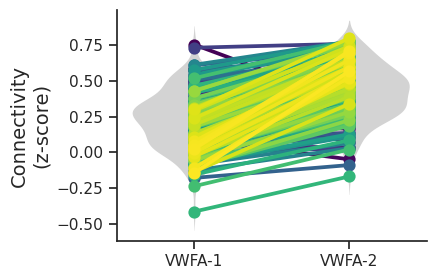

In [25]:
fig, ax = plt.subplots(figsize =(4, 3))

sns.violinplot(data=plot_data_long,x='IFS_ROI',y='FC',color='lightgray',legend=False, linewidth=0)
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',hue='Delta',palette='binary',legend=False,markers='o')
sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',hue='Delta',errorbar=('ci',95),palette='viridis',legend=False,markers='o',linewidth=0.5,size=0.5)
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',errorbar=('ci',95),color='black',legend=False,markers='o')
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',color='gray',legend=False,markers='o')
ax.get_legend().remove()
#plt.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left', borderaxespad=0)
plt.ylabel('Connectivity\n(z-score)',fontsize=14,fontname='Helvetica')
plt.xlabel('')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

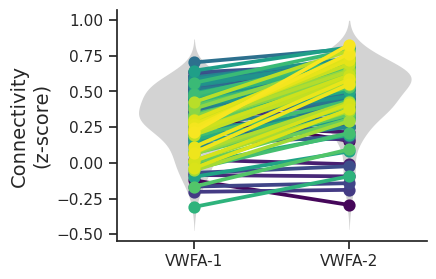

In [16]:
# MOVIE
fig, ax = plt.subplots(figsize =(4, 3))

sns.violinplot(data=plot_data_long,x='IFS_ROI',y='FC',color='lightgray',legend=False, linewidth=0)
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',hue='Delta',palette='binary',legend=False,markers='o')
sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',hue='Delta',errorbar=('ci',95),palette='viridis',legend=False,markers='o',alpha=0.1,linewidth=0.5,size=0.5)
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',errorbar=('ci',95),color='black',legend=False,markers='o')
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',color='gray',legend=False,markers='o')
ax.get_legend().remove()
#plt.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left', borderaxespad=0)
plt.ylabel('Connectivity\n(z-score)',fontsize=14,fontname='Helvetica')
plt.xlabel('')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [26]:
stats.ttest_rel(plot_data['VWFA-2_IFS'],plot_data['VWFA-1_IFS'])

Ttest_relResult(statistic=15.778964355284128, pvalue=3.617601869554694e-38)

# Face ROIs

In [30]:
# Try to color by magnitude of difference
#plot_data['Delta'] =  plot_data.apply(lambda row: row.vwfa2_IFSwords - row.vwfa1_IFSwords, axis = 1)
plot_data['Delta'] =  plot_data.apply(lambda row: row['FFA-2_IFS'] - row['FFA-1_IFS'], axis = 1)
plot_data_long = plot_data.melt(id_vars=['sub','Delta'],value_vars=['FFA-1_IFS','FFA-2_IFS'],var_name='IFS_ROI',value_name = 'FC',ignore_index=True)
plot_data_long

/tmp/ipykernel_12999/44519332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['Delta'] =  plot_data.apply(lambda row: row['FFA-2_IFS'] - row['FFA-1_IFS'], axis = 1)


,sub,Delta,IFS_ROI,FC
0,sub-NDARAA948VFH,-0.050512,FFA-1_IFS,0.300654
1,sub-NDARAB458VK9,0.229429,FFA-1_IFS,0.243256
2,sub-NDARAC349YUC,0.167468,FFA-1_IFS,0.171103
3,sub-NDARAC350BZ0,0.066037,FFA-1_IFS,0.088336
4,sub-NDARAG340ERT,0.004066,FFA-1_IFS,0.439008
...,...,...,...,...
443,sub-NDARZL113CU0,0.130391,FFA-2_IFS,0.348808
444,sub-NDARZM903TNL,0.186014,FFA-2_IFS,0.224935
445,sub-NDARZT940RZG,0.119125,FFA-2_IFS,0.333186
446,sub-NDARZW873DN3,0.156792,FFA-2_IFS,0.311543


Ttest_relResult(statistic=3.622665406501759, pvalue=0.00036106549209552615)

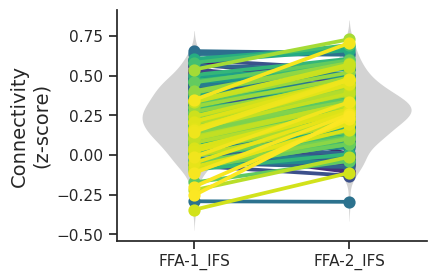

In [32]:
# REST + FACES
fig, ax = plt.subplots(figsize =(4, 3))

sns.violinplot(data=plot_data_long,x='IFS_ROI',y='FC',color='lightgray',legend=False, linewidth=0)
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',hue='Delta',palette='binary',legend=False,markers='o')
sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',hue='Delta',errorbar=('ci',95),palette='viridis',legend=False,markers='o',alpha=0.1,linewidth=0.5,size=0.5)
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',errorbar=('ci',95),color='black',legend=False,markers='o')
#sns.pointplot(data=plot_data_long,x='IFS_ROI',y='FC',color='gray',legend=False,markers='o')
ax.get_legend().remove()
#plt.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left', borderaxespad=0)
plt.ylabel('Connectivity\n(z-score)',fontsize=14,fontname='Helvetica')
plt.xlabel('')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
stats.ttest_rel(plot_data['FFA-2_IFS'],plot_data['FFA-1_IFS'])

# Correlate with behavior

In [27]:
behav_data = sub_list[['participant_id','Age','EHQ_Total','Barratt_Total','WIAT_Word_Stnd','WIAT_Word_Raw','TOWRE_Total_Scaled','WIAT_Num_Stnd','meanFD_movieDM','Gender']]

In [33]:
behav_data = behav_data.rename(columns={'participant_id': 'sub'})
plot_data=pd.merge(plot_data,behav_data,on='sub')

In [34]:
plot_data

,sub,VWFA-1_IFS,VWFA-2_IFS,Delta,Age,EHQ_Total,Barratt_Total,WIAT_Word_Stnd,WIAT_Word_Raw,TOWRE_Total_Scaled,WIAT_Num_Stnd,meanFD_movieDM,Gender
0,sub-NDARAA948VFH,0.267867,0.177036,-0.090831,7.982660,90.05,53.0,96,26,103.0,96,0.117614,Female
1,sub-NDARAB458VK9,0.529696,0.639191,0.109495,12.836185,80.04,42.5,110,62,103.0,94,NaN,Male
2,sub-NDARAC349YUC,0.303648,0.306566,0.002919,10.051791,86.71,18.0,105,49,103.0,98,NaN,Female
3,sub-NDARAC350BZ0,-0.103622,0.224779,0.328402,12.921058,66.77,56.5,117,67,130.0,101,0.190808,Male
4,sub-NDARAG340ERT,0.380380,0.342235,-0.038145,10.725872,93.38,21.0,104,52,97.0,101,0.301833,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,sub-NDARZL113CU0,0.077073,0.097121,0.020048,6.980492,93.38,39.0,113,29,115.0,98,NaN,Female
220,sub-NDARZM903TNL,-0.016170,0.237100,0.253269,9.586356,100.05,63.0,116,55,120.0,105,0.141024,Female
221,sub-NDARZT940RZG,0.511668,0.538214,0.026546,14.640543,100.05,49.0,116,69,96.0,130,0.125923,Female
222,sub-NDARZW873DN3,0.076697,0.645213,0.568515,13.436344,73.37,58.0,93,51,96.0,82,0.142168,Female


-0.04407524436069243
0.5116399527926058


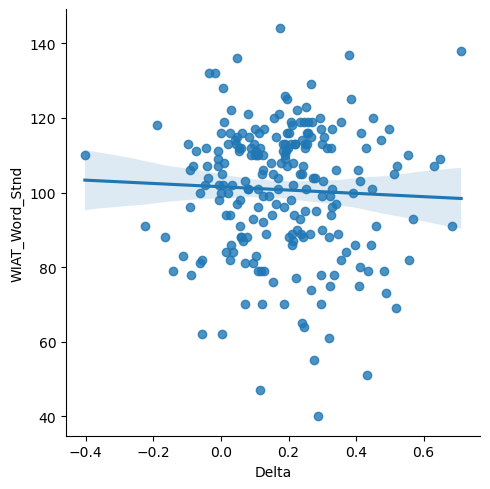

In [41]:
sns.lmplot(data=big_df,x='Delta',y='WIAT_Word_Stnd')
#scat_axes[roi_i,cluster_i].text(xpos, 0.4, "r = {:.3f}\np = {:.3f}".format(cor_val[0],p_val), horizontalalignment='left', size='medium', weight='semibold')
cor_val, p_val = stats.pearsonr(big_df['Delta'],big_df['WIAT_Word_Stnd'])
print(cor_val)
print(p_val)

In [75]:
rh_data = plot_data[plot_data['EHQ_Total']>80]
#cor_val, p_val = stats.pearsonr(rh_data['VWFA-1_IFS'],rh_data['WIAT_Word_Stnd'])
cor_val, p_val = stats.pearsonr(rh_data['VWFA-2_IFS'],rh_data['Age'])
print(cor_val)
print(p_val)
print(len(rh_data))

0.17093397165877194
0.06656431584190059
116


In [87]:
plot_data.corr()

,VWFA-1_IFS,VWFA-2_IFS,Delta,Age,EHQ_Total,Barratt_Total,WIAT_Word_Stnd,WIAT_Word_Raw,TOWRE_Total_Scaled,WIAT_Num_Stnd,meanFD_movieDM
VWFA-1_IFS,1.000000,0.576557,-0.493715,0.208134,0.074287,0.055352,0.074122,0.191109,0.021882,-0.010698,-0.027841
VWFA-2_IFS,0.576557,1.000000,0.425877,0.125098,0.082729,0.112667,0.035708,0.107239,-0.007669,-0.077985,0.049602
Delta,-0.493715,0.425877,1.000000,-0.097334,0.005789,0.058063,-0.044075,-0.097489,-0.032250,-0.071155,0.078503
Age,0.208134,0.125098,-0.097334,1.000000,0.043241,0.127721,0.059949,0.630096,0.030682,-0.122024,-0.199345
EHQ_Total,0.074287,0.082729,0.005789,0.043241,1.000000,0.119263,0.098902,0.147129,0.088082,0.019540,0.021452
Barratt_Total,0.055352,0.112667,0.058063,0.127721,0.119263,1.000000,0.171080,0.178269,0.149035,0.100030,-0.014197
WIAT_Word_Stnd,0.074122,0.035708,-0.044075,0.059949,0.098902,0.171080,1.000000,0.771585,0.838589,0.627155,-0.227234
WIAT_Word_Raw,0.191109,0.107239,-0.097489,0.630096,0.147129,0.178269,0.771585,1.000000,0.630191,0.373590,-0.259160
TOWRE_Total_Scaled,0.021882,-0.007669,-0.032250,0.030682,0.088082,0.149035,0.838589,0.630191,1.000000,0.605837,-0.311905
WIAT_Num_Stnd,-0.010698,-0.077985,-0.071155,-0.122024,0.019540,0.100030,0.627155,0.373590,0.605837,1.000000,-0.142897


<AxesSubplot:xlabel='VWFA2', ylabel='WIAT_Word_Raw'>

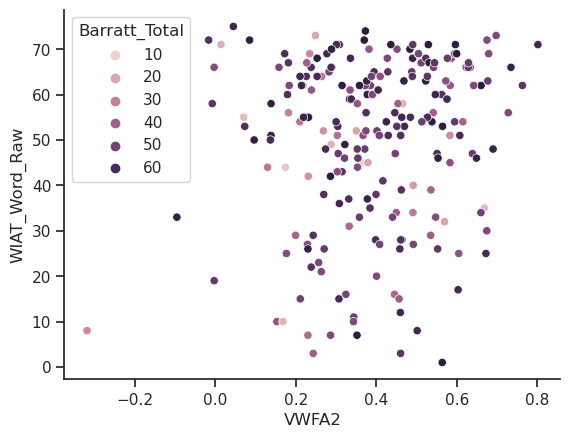

In [63]:
sns.scatterplot(data=plot_data,x='VWFA2',y='WIAT_Word_Raw',hue='Barratt_Total')

In [120]:
# MOVIE DATA
plot_data.corr()

,VWFA1,VWFA2,Delta,Age,Barratt_Total,WIAT_Word_Stnd,WIAT_Word_Raw,TOWRE_Total_Scaled,WIAT_Num_Stnd,meanFD_movieDM,Ratio
VWFA1,1.000000,0.790556,-0.235099,0.104518,-0.042664,0.055020,0.107290,0.035535,0.076578,0.040382,-0.073735
VWFA2,0.790556,1.000000,0.409367,0.090735,0.004543,0.099757,0.124267,0.094884,0.064394,0.056997,0.160138
Delta,-0.235099,0.409367,1.000000,-0.011703,0.070741,0.076360,0.037388,0.096400,-0.011885,0.030302,0.364022
Age,0.104518,0.090735,-0.011703,1.000000,0.106741,0.088827,0.647461,0.139405,-0.094494,-0.174706,-0.057906
Barratt_Total,-0.042664,0.004543,0.070741,0.106741,1.000000,0.234133,0.195327,0.325725,0.167063,0.046641,-0.078969
WIAT_Word_Stnd,0.055020,0.099757,0.076360,0.088827,0.234133,1.000000,0.780500,0.859297,0.630919,-0.259737,0.131520
WIAT_Word_Raw,0.107290,0.124267,0.037388,0.647461,0.195327,0.780500,1.000000,0.713395,0.414192,-0.293242,0.046709
TOWRE_Total_Scaled,0.035535,0.094884,0.096400,0.139405,0.325725,0.859297,0.713395,1.000000,0.596393,-0.288031,0.124828
WIAT_Num_Stnd,0.076578,0.064394,-0.011885,-0.094494,0.167063,0.630919,0.414192,0.596393,1.000000,-0.155359,0.005022
meanFD_movieDM,0.040382,0.056997,0.030302,-0.174706,0.046641,-0.259737,-0.293242,-0.288031,-0.155359,1.000000,-0.072694


In [21]:
plot_data['Ratio'] =  plot_data.apply(lambda row: (row['VWFA2'] - row['VWFA1'])/(row['VWFA2'] + row['VWFA1']), axis = 1)

<AxesSubplot:xlabel='Ratio', ylabel='WIAT_Word_Stnd'>

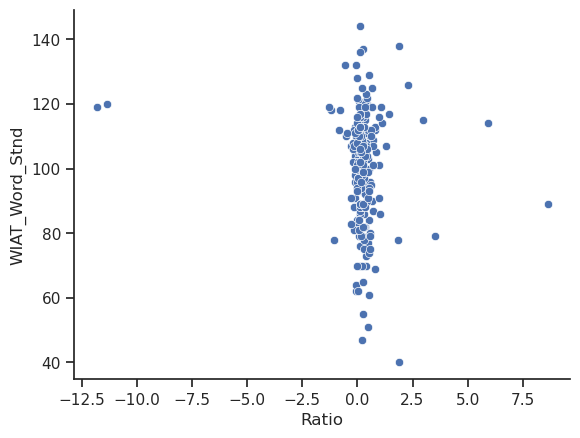

In [22]:
sns.scatterplot(data=plot_data,x='Ratio',y='WIAT_Word_Stnd')

In [23]:
plot_data.corr()

,VWFA1,VWFA2,Delta,Age,EHQ_Total,Barratt_Total,WIAT_Word_Stnd,WIAT_Word_Raw,TOWRE_Total_Scaled,WIAT_Num_Stnd,meanFD_movieDM,Ratio
VWFA1,1.000000,0.582655,-0.487447,0.172691,0.056722,0.037260,0.062528,0.164675,0.013498,-0.043597,0.027113,-0.097451
VWFA2,0.582655,1.000000,0.425614,0.160490,0.062708,0.133692,0.042350,0.121434,0.013792,-0.105936,0.081890,0.073181
Delta,-0.487447,0.425614,1.000000,-0.019856,0.004215,0.101285,-0.024122,-0.052890,-0.000183,-0.065271,0.057478,0.187127
Age,0.172691,0.160490,-0.019856,1.000000,0.043241,0.127721,0.059949,0.630096,0.030682,-0.122024,-0.199345,-0.006124
EHQ_Total,0.056722,0.062708,0.004215,0.043241,1.000000,0.119263,0.098902,0.147129,0.088082,0.019540,0.021452,0.013924
Barratt_Total,0.037260,0.133692,0.101285,0.127721,0.119263,1.000000,0.171080,0.178269,0.149035,0.100030,-0.014197,0.119892
WIAT_Word_Stnd,0.062528,0.042350,-0.024122,0.059949,0.098902,0.171080,1.000000,0.771585,0.838589,0.627155,-0.227234,-0.112185
WIAT_Word_Raw,0.164675,0.121434,-0.052890,0.630096,0.147129,0.178269,0.771585,1.000000,0.630191,0.373590,-0.259160,-0.071711
TOWRE_Total_Scaled,0.013498,0.013792,-0.000183,0.030682,0.088082,0.149035,0.838589,0.630191,1.000000,0.605837,-0.311905,-0.066460
WIAT_Num_Stnd,-0.043597,-0.105936,-0.065271,-0.122024,0.019540,0.100030,0.627155,0.373590,0.605837,1.000000,-0.142897,-0.131435


<AxesSubplot:>

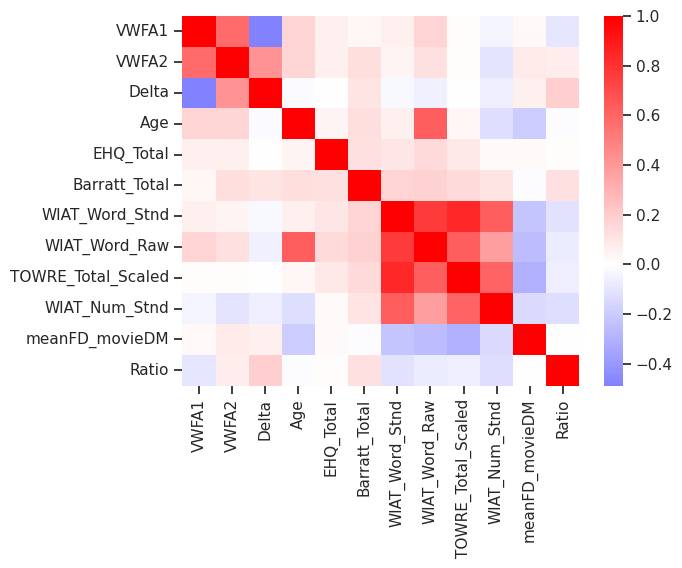

In [64]:
sns.heatmap(plot_data.corr(),annot=False,cmap = 'bwr',center =0)